In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import pylab as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

from sklearn.metrics import f1_score, accuracy_score,make_scorer
from sklearn.metrics import classification_report, confusion_matrix
import pickle

## Data loading and cleaning

In [2]:
# Top 200 hit songs
data_hit = pd.read_csv('data/Top_200.csv')
data_hit = data_hit.dropna()

def get_id(url):
    return url.split('/')[-1]

# Convert link to ID
data_hit["ID"] = data_hit["Link"].apply(get_id)

# Remove duplicate
data_hit = data_hit.drop_duplicates(subset=['ID'])
data_hit.head()

,Rank,Track,Artist,Streams,Link,Week,Album_Name,Duration_MS,Explicit,Track_Number_on_Album,...,Key,Mode,Instrumentalness,Liveness,Loudness,Speechiness,Valence,Tempo,Time Signature,Popularity
0,1,Starboy,The Weeknd,25734078,https://open.spotify.com/track/5aAx2yezTd8zXrk...,1/6/2017,Starboy,230453,True,1,...,7,1,0.000003,0.134,-7.028,0.2820,0.5350,186.054,4,1
1,2,Closer,The Chainsmokers,23519705,https://open.spotify.com/track/7BKLCZ1jbUBVqRi...,1/6/2017,Closer,244960,False,1,...,8,1,0.000000,0.111,-5.599,0.0338,0.6610,95.010,4,86
2,3,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,21216399,https://open.spotify.com/track/5knuzwU65gJK7IF...,1/6/2017,Rockabye (feat. Sean Paul & Anne-Marie),251088,False,1,...,9,0,0.000000,0.180,-4.068,0.0523,0.7420,101.965,4,78
3,4,Let Me Love You,DJ Snake,19852704,https://open.spotify.com/track/4pdPtRcBmOSQDlJ...,1/6/2017,Encore,205946,False,13,...,8,1,0.000010,0.122,-5.309,0.0576,0.1420,199.864,4,0
4,5,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,18316326,https://open.spotify.com/track/3NdDpSvN911VPGi...,1/6/2017,I Don’t Wanna Live Forever (Fifty Shades Darker),245200,False,1,...,0,1,0.000013,0.325,-8.374,0.0585,0.0862,117.973,4,1


In [3]:
# Random song dataset
data_n_hit = pd.read_csv('data/Random_song.csv')
data_n_hit = data_n_hit.drop_duplicates(subset=['ID'])
data_n_hit = data_n_hit.dropna()
data_n_hit.head()

,ID,Artist,Track,Popularity,Acousticness,Danceablility,Energy,Key,Mode,Instrumentalness,Liveness,Loudness,Speechiness,Valence,Tempo,Time Signature
0,2b8fOow8UzyDFAE27YhOZM,Maroon 5,Memories,99,0.8370,0.764,0.320,11,1,0.00000,0.0822,-7.209,0.0546,0.575,91.019,4
1,6WrI0LAC5M1Rw2MnX2ZvEg,Dua Lipa,Don't Start Now,95,0.0125,0.794,0.793,11,0,0.00000,0.0952,-4.521,0.0842,0.677,123.941,4
2,3ZCTVFBt2Brf31RLEnCkWJ,Billie Eilish,everything i wanted,94,0.9020,0.704,0.225,6,0,0.65700,0.1060,-14.454,0.0994,0.243,120.006,4
3,696DnlkuDOXcMAnKlTgXXK,Arizona Zervas,ROXANNE,88,0.0522,0.621,0.601,6,0,0.00000,0.4600,-5.616,0.1480,0.457,116.735,5
4,4VginDwYTP2eaHJzO0QMjG,Post Malone,Circles,68,0.2330,0.704,0.758,0,1,0.00144,0.0924,-3.537,0.0402,0.534,120.003,4


### Label hit song and non hit song

In [4]:
features = ['ID','Track', 'Acousticness', 'Danceablility','Energy','Key','Mode','Instrumentalness',
            'Liveness','Loudness','Speechiness','Valence','Tempo', 'Popularity']
select_hit = data_hit[features]
select_hit['Label'] = 1

# Get 5000 random songs
select_n_hit = data_n_hit[5000:10000][features]
select_n_hit['Label'] = 0

<ipython-input-4-f89c52349650>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_hit['Label'] = 1


In [5]:
data = pd.concat([select_hit,select_n_hit])
#select_df.groupby('Label').count()
label_ = data.groupby('Label').size()
print("Number of hit songs : {} - Number of n_hit songs: {}".format(label_[1],label_[0]))
data = data.drop_duplicates(subset=['ID'])
label_ = data.groupby('Label').size()
print("Number of hit songs : {} - Number of n_hit songs: {}".format(label_[1],label_[0]))

# Get label
y = np.array(data['Label'])
data.head()

Number of hit songs : 4242 - Number of n_hit songs: 5000
Number of hit songs : 4242 - Number of n_hit songs: 4800


,ID,Track,Acousticness,Danceablility,Energy,Key,Mode,Instrumentalness,Liveness,Loudness,Speechiness,Valence,Tempo,Popularity,Label
0,5aAx2yezTd8zXrkmtKl66Z,Starboy,0.1650,0.681,0.594,7,1,0.000003,0.134,-7.028,0.2820,0.5350,186.054,1,1
1,7BKLCZ1jbUBVqRi2FVlTVw,Closer,0.4140,0.748,0.524,8,1,0.000000,0.111,-5.599,0.0338,0.6610,95.010,86,1
2,5knuzwU65gJK7IF5yJsuaW,Rockabye (feat. Sean Paul & Anne-Marie),0.4060,0.720,0.763,9,0,0.000000,0.180,-4.068,0.0523,0.7420,101.965,78,1
3,4pdPtRcBmOSQDlJ3Fk945m,Let Me Love You,0.0784,0.476,0.718,8,1,0.000010,0.122,-5.309,0.0576,0.1420,199.864,0,1
4,3NdDpSvN911VPGivFlV5d0,I Don’t Wanna Live Forever (Fifty Shades Darke...,0.0631,0.735,0.451,0,1,0.000013,0.325,-8.374,0.0585,0.0862,117.973,1,1


### Visualize hit song and non-hit song

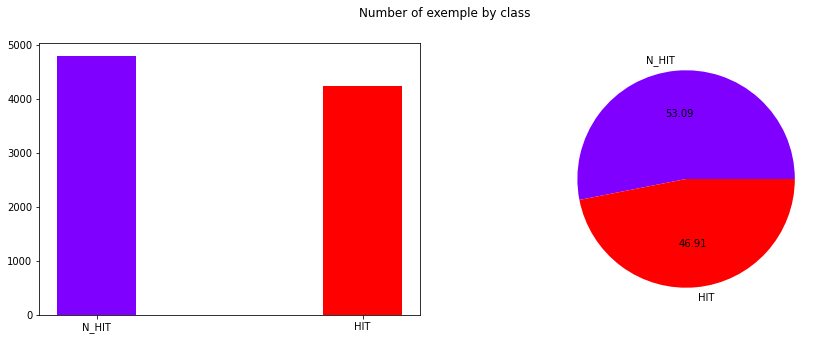

In [6]:
count_label = {"N_HIT":label_[0],"HIT":label_[1]}
colors = cm.rainbow(np.linspace(0, 1, len(count_label)))

plt.figure(1,figsize=(15,5))
plt.suptitle("Number of exemple by class")
plt.subplot(1,2,1)
plt.bar(count_label.keys(), count_label.values(),width=0.3,color=colors)
plt.subplot(1,2,2)
plt.pie(count_label.values(), labels = count_label.keys(), autopct = '%0.2f',colors=colors)
plt.savefig('Figures/hit_vs_nonhit.png', dpi=300, format='png')
plt.show()


In [7]:
# correlation
corr = data.corr()
corr

,Acousticness,Danceablility,Energy,Key,Mode,Instrumentalness,Liveness,Loudness,Speechiness,Valence,Tempo,Popularity,Label
Acousticness,1.000000,-0.413230,-0.770325,-0.008032,0.074524,0.517238,-0.123013,-0.692584,-0.218310,-0.327771,-0.209782,-0.026872,-0.297560
Danceablility,-0.413230,1.000000,0.342699,0.027184,-0.102685,-0.465810,-0.130966,0.534831,0.261961,0.488254,0.076913,0.085162,0.471769
Energy,-0.770325,0.342699,1.000000,0.013514,-0.068902,-0.516066,0.217569,0.784649,0.163678,0.453360,0.249300,0.011921,0.227023
Key,-0.008032,0.027184,0.013514,1.000000,-0.164950,-0.009574,-0.012428,0.008393,0.041759,0.035439,0.004616,0.005049,0.009241
Mode,0.074524,-0.102685,-0.068902,-0.164950,1.000000,0.012720,-0.001033,-0.059688,-0.079129,-0.033447,-0.008038,-0.037866,-0.084652
Instrumentalness,0.517238,-0.465810,-0.516066,-0.009574,0.012720,1.000000,-0.021939,-0.716532,-0.191911,-0.393694,-0.173004,-0.009764,-0.417842
Liveness,-0.123013,-0.130966,0.217569,-0.012428,-0.001033,-0.021939,1.000000,0.061907,0.099558,-0.001288,0.006187,-0.021361,-0.030755
Loudness,-0.692584,0.534831,0.784649,0.008393,-0.059688,-0.716532,0.061907,1.000000,0.182903,0.445402,0.243267,0.025893,0.401383
Speechiness,-0.218310,0.261961,0.163678,0.041759,-0.079129,-0.191911,0.099558,0.182903,1.000000,0.104191,0.142137,0.067982,0.290237
Valence,-0.327771,0.488254,0.453360,0.035439,-0.033447,-0.393694,-0.001288,0.445402,0.104191,1.000000,0.140966,0.039476,0.163918


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

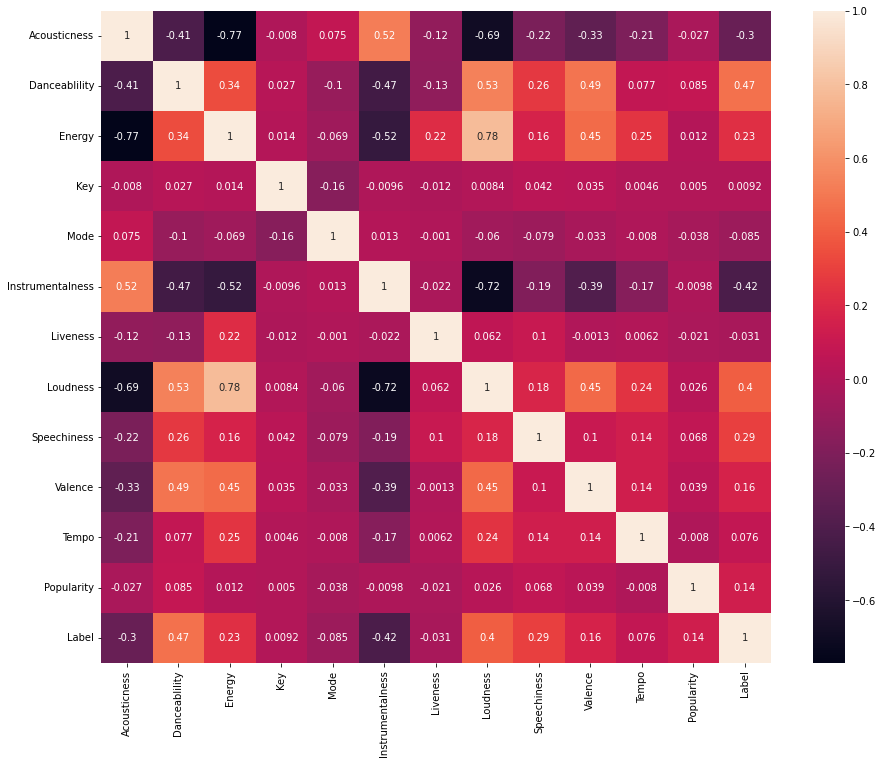

In [8]:
# correlation heatmap
plt.figure(figsize=(15,12))
sns.heatmap(corr, annot=True)
plt.tight_layout

## Exploratory Data Analysis

### Radar plot

In [9]:
df_radar = data[['Acousticness','Danceablility','Energy','Mode','Instrumentalness','Liveness','Speechiness','Valence','Label']]
labels = list(df_radar.iloc[:,0:-1])
labels

['Acousticness',
 'Danceablility',
 'Energy',
 'Mode',
 'Instrumentalness',
 'Liveness',
 'Speechiness',
 'Valence']

In [10]:
df_hit = df_radar[df_radar['Label']==1]
df_nonhit = df_radar[df_radar['Label']==0]
del df_hit['Label']
del df_nonhit['Label']

In [11]:
hit = df_hit.mean().tolist()
nonhit = df_nonhit.mean().tolist()

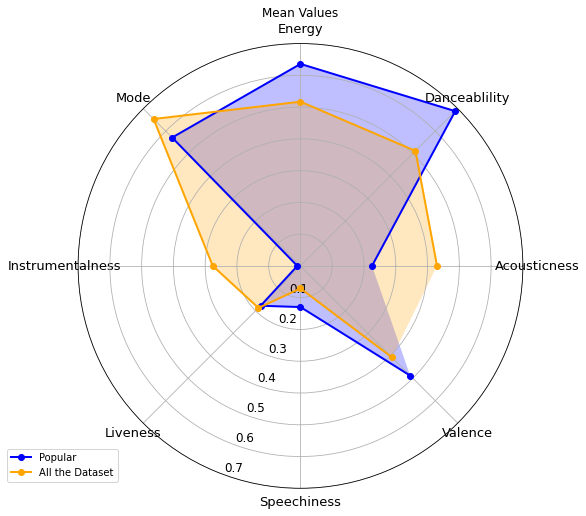

In [12]:
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
fig = plt.figure(figsize = (18,18))

ax = fig.add_subplot(221, polar=True)
ax.plot(angles, hit, 'o-', linewidth=2, label = "Popular", color= 'blue')
ax.fill(angles, hit, alpha=0.25, facecolor='blue')
ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13)


ax.set_rlabel_position(250)
plt.yticks([0.1 , 0.2 , 0.3 , 0.4, 0.5,  0.6, 0.7], ["0.1",'0.2', "0.3", "0.4", "0.5", "0.6", '0.7'  ], size=12)
plt.ylim(0,0.7)

ax.plot(angles, nonhit, 'o-', linewidth=2, label = "All the Dataset", color= 'orange')
ax.fill(angles, nonhit, alpha=0.25, facecolor='orange')
ax.set_title('Mean Values')
ax.grid(True)

plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))

### Boxplot and Violinplot

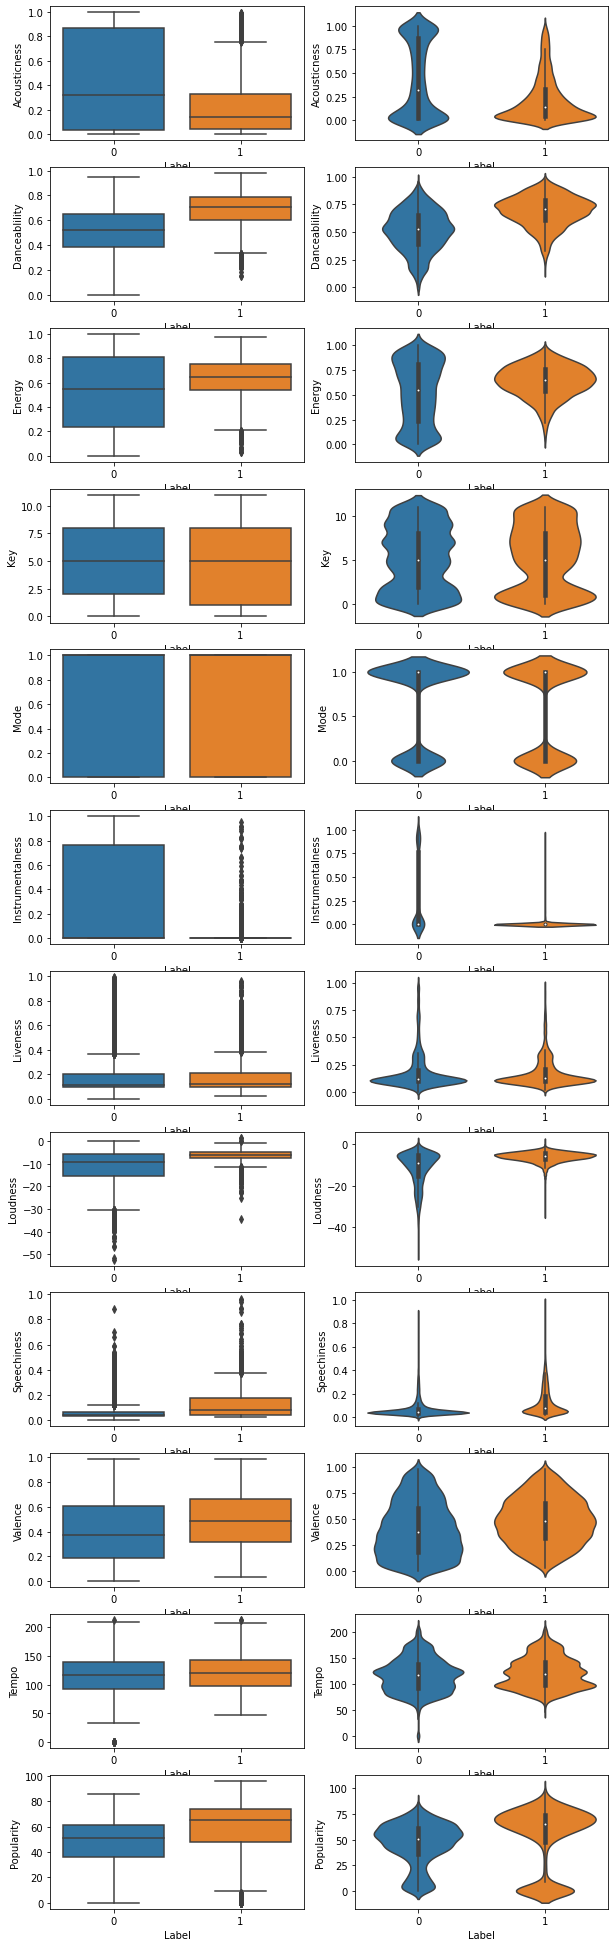

In [13]:
df_chart=data.iloc[:,2:]
feature=list(df_chart.iloc[:,0:-1])
fig, axes = plt.subplots(12, 2, figsize=[10, 35])

for row, var in enumerate(feature):
    sns.boxplot(x='Label', y=var, data=df_chart, ax=axes[row, 0])
    sns.violinplot(x='Label', y=var, data=df_chart, ax=axes[row, 1])

plt.show()


### Histogram

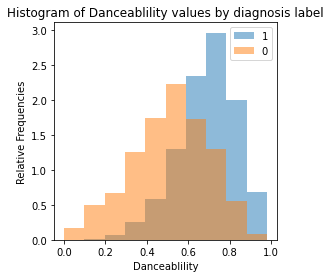

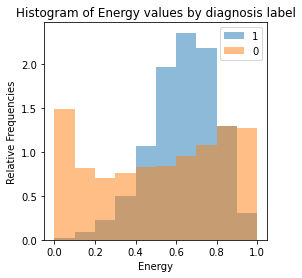

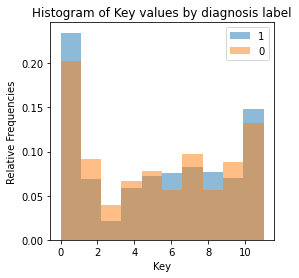

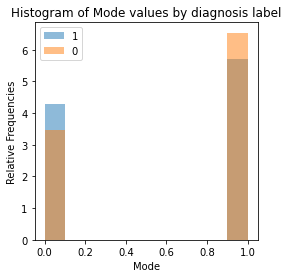

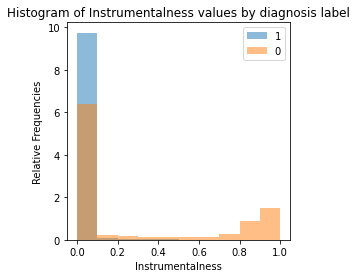

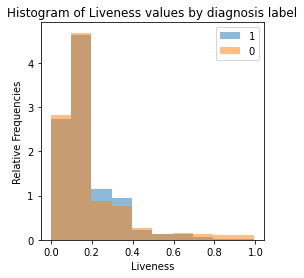

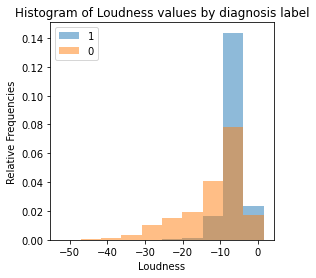

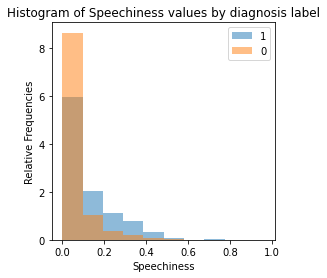

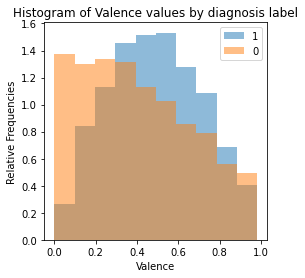

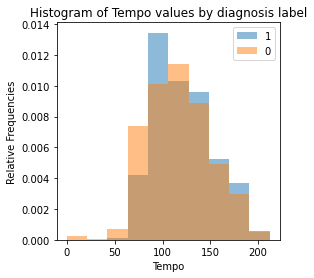

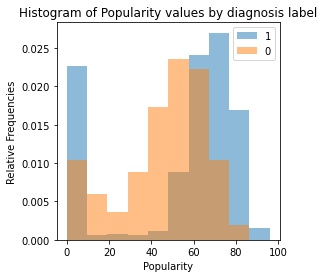

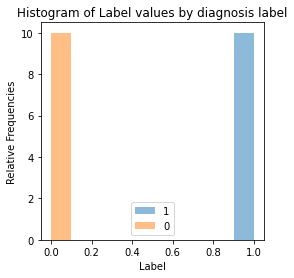

In [14]:
categories = data['Label'].unique()

for column in data.columns[3:]:
    fig, ax = plt.subplots(figsize=(4,4))
    bin_range = (data[column].min(),data[column].max())

    for c in categories:
        plt.hist(data[data['Label']==c][column],alpha=0.5,label=c,range=bin_range,bins=10,density=True)
    plt.legend()
    plt.ylabel('Relative Frequencies')
    plt.xlabel(column)
    plt.title(f'Histogram of {column} values by diagnosis label')
    
    figtitle = f'Figures/histogram_categories_{column}.png'
    plt.savefig(figtitle, dpi=300, format='png')
    plt.show()

## Data preprocess

In [15]:
#preprocess data
cat_ft  = ['Key', 'Mode']
num_ft = ['Acousticness', 'Danceablility','Energy','Instrumentalness','Liveness','Loudness','Speechiness','Valence','Tempo']

# ordinal encoder
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
            ('num', numeric_transformer, num_ft),
            ('cat', categorical_transformer, cat_ft)])
X = data[num_ft + cat_ft]
y = data['Label']

In [16]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
def MLpipe_KFold_acc(ML_algo, param_grid):
    
    #applies KFold with 5 folds to other
    kf = KFold(n_splits=5,shuffle=True,random_state=42)
           
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('scaler', StandardScaler()),
                                     ('classifier', ML_algo)])
    # use GridSearchCV
    # GridSearchCV loops through all parameter combinations and collects the results
    #use acc as score
    grid = GridSearchCV(model_pipeline, param_grid=param_grid,scoring = make_scorer(accuracy_score, greater_is_better=True),
                            cv=kf, return_train_score = True, n_jobs=-1, verbose=False)

    # this line actually fits the model on other
    grid.fit(X_test, y_test)
        
    #best_param = grid.best_params_
    y_predict = grid.predict(X_test)
        
    acc_test= accuracy_score(y_test,  y_predict)
    acc_train = accuracy_score(y_train,  grid.predict(X_train))
    F1_score = f1_score(y_test,  y_predict) 
    best_models = grid.best_estimator_
        
    return best_models, acc_test, acc_train, F1_score 

### PCA

Learning Base Dimension:  (9042, 11)


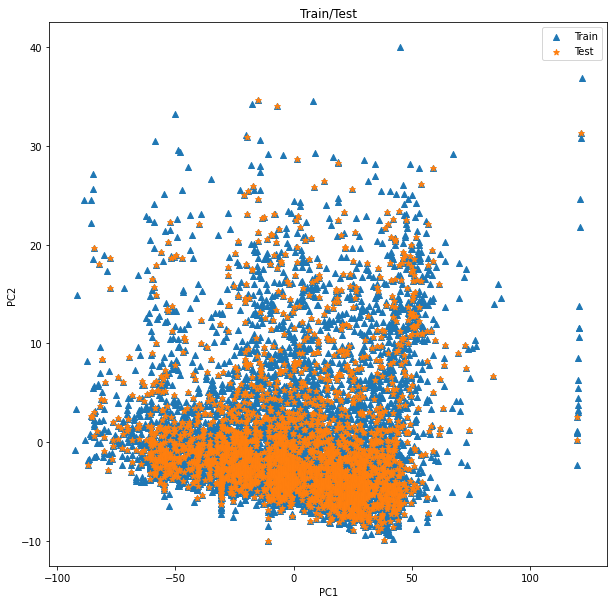

In [18]:
n_components = 2 
print('Learning Base Dimension: ',X.shape)
# using sklearn    
pca = PCA(n_components)
pca_train = pca.fit_transform(X)
pca_test = pca.transform(X_test)

n_components = pca.n_components_
plt.figure(1,figsize=(10,10))
plt.scatter(pca_train[:, 0], pca_train[:, 1],marker='^', label = "Train")
plt.scatter(pca_test[:, 0], pca_test[:, 1],marker='*',label = "Test")
plt.legend()
plt.title("Train/Test")
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.show()

## Modeling

### Logistic Regression

In [19]:
param_grid_LR = {'classifier__C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
              'classifier__max_iter': [100000]}

LR_models, LR_acc_test, LR_acc_train, LR_f1 = MLpipe_KFold_acc(LogisticRegression(penalty='l1', solver='saga'),param_grid_LR)
print("Accuracy on test set : ",LR_acc_test)
print("Accuracy on train set : ",LR_acc_train)
print("F1 score: ",LR_f1)


Accuracy on test set :  0.7795798009583487
Accuracy on train set :  0.778006004108074
F1 score:  0.7803085966201322


### SVM

In [20]:
param_grid_SVC = {'classifier__C': [0.1,1, 10],  
              'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'classifier__kernel': ['rbf', 'poly']}  

SVC_models, SVC_acc_test, SVC_acc_train, SVC_f1 = MLpipe_KFold_acc(SVC(probability=True),param_grid_SVC)
print("Accuracy on test set : ",SVC_acc_test)
print("Accuracy on train set : ",SVC_acc_train)
print("F1 score: ",SVC_f1)


Accuracy on test set :  0.8098046443051972
Accuracy on train set :  0.7852741349344288
F1 score:  0.8133140376266281


### Random Forest

In [21]:
param_grid_RF = {'classifier__criterion': ['entropy', 'gini'],
    'classifier__n_estimators': [800, 1000, 5000],
              'classifier__max_depth': [1,2,3,4,5],
              'classifier__max_features': ['auto', 'log2'],   
            }

RF_models, RF_acc_test, RF_acc_train, RF_f1  = MLpipe_KFold_acc(RandomForestClassifier(),param_grid_RF)
print("Accuracy on test set : ",RF_acc_test)
print("Accuracy on train set : ",RF_acc_train)
print("F1 score: ",RF_f1)

Accuracy on test set :  0.8105418356063399
Accuracy on train set :  0.7881181861273503
F1 score:  0.8159025787965616


### XGBoost

In [22]:
param_grid_XGB = {'classifier__max_depth': [1, 3, 5, 10, 30],
                  'classifier__eval_metric':['mlogloss']}
XGB_models, XGB_acc_test, XGB_acc_train, XGB_f1 = MLpipe_KFold_acc(XGBClassifier(use_label_encoder=False),param_grid_XGB)
print("Accuracy on test set : ",XGB_acc_test)
print("Accuracy on train set : ",XGB_acc_train)
print("F1 score: ",XGB_f1)

Accuracy on test set :  0.8138591964614817
Accuracy on train set :  0.8006004108073945
F1 score:  0.815086049066276


### Naive Bayes classifier

In [23]:
from sklearn.naive_bayes import GaussianNB
param_grid_NB ={'classifier__priors': [None],
                 'classifier__var_smoothing': [0.00000001, 0.000000001, 0.00000001]
                 }
NB_models, NB_acc_test, NB_acc_train, NB_f1  = MLpipe_KFold_acc(GaussianNB(),param_grid_NB)
print("Accuracy on test set : ",NB_acc_test)
print("Accuracy on train set : ",NB_acc_train)
print("F1 score: ",NB_f1)

Accuracy on test set :  0.706966457795798
Accuracy on train set :  0.7040606730921156
F1 score:  0.7459252157238734


### Comparison Models

No handles with labels found to put in legend.


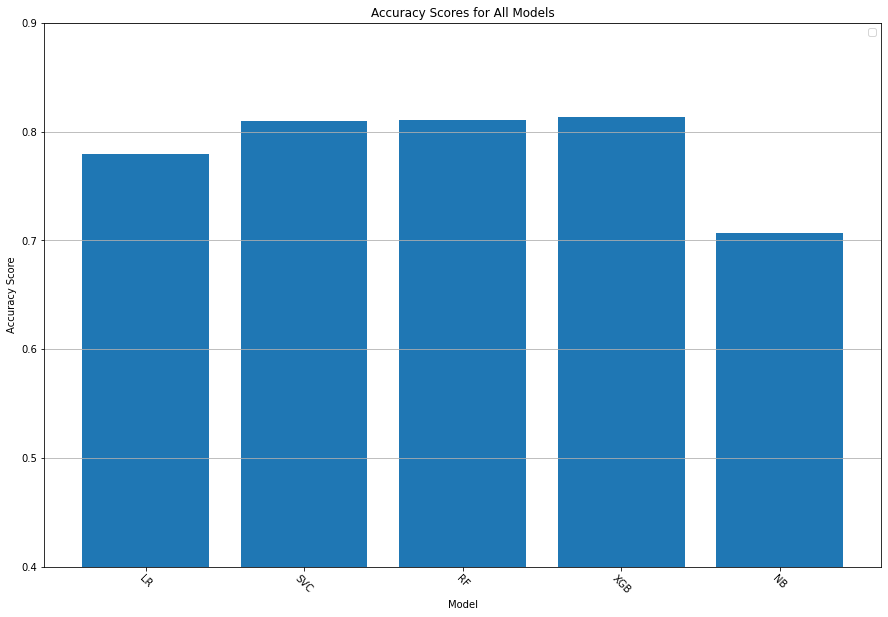

In [24]:
fig, ax = plt.subplots(figsize=(15,10))

labels = ['LR','SVC', 'RF', 'XGB','NB']
scores = [LR_acc_test, SVC_acc_test, RF_acc_test, XGB_acc_test, NB_acc_test]

plt.bar(labels, scores, capsize=2)
plt.ylim([0.4,0.9])
plt.xticks(rotation=-45)
plt.grid(axis='y')
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.legend()
plt.title("Accuracy Scores for All Models")
plt.savefig('Figures/acc_bar_plot.png', dpi=300, format='png')
plt.show()

After comparing the F1 score and accuracy score for all of my models, I can conclude that XGBoost produced the best results for the goal of this project. When deciding which metric I should be evaluating my model on, the f1 score and accuracy seemed most appropriate. When curating a music playlist for a massive audience, it's important to be able to have a model that recognizes as many hits as possible while also identifying the songs that may not fit and therefore cause the listener to disengage from the content.

In [25]:
# pickle list object

pickle.dump(XGB_models, open("model.pickle.dat", "wb"))
# model_pickle.close()

### ROC curve

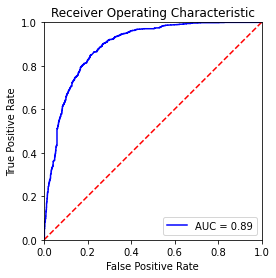

In [26]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = SVC_models.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', label='baseline')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('Figures/ROC_curves.png', dpi=300, format='png')
plt.show()


### Consfusion Matrix

In [27]:
y_pred = XGB_models.predict(X_test)

In [30]:
def conf_matrix(y_test, y_pred, idx_to_classes):
    cf_matrix = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in idx_to_classes], columns = [i for i in idx_to_classes])    
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

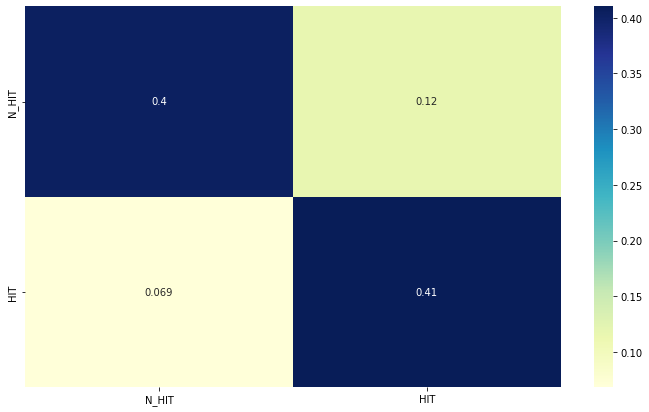

In [31]:
conf_matrix(y_test, y_pred, count_label.keys())
plt.savefig('Figures/confusion_matrixs.png', dpi=300, format='png')
plt.show()

### Testing

In [32]:
test_table = data_n_hit[100:200][features]
test = test_table.drop(columns=['ID', 'Track'])

In [33]:
predict = XGB_models.predict(test)

In [34]:
predict 

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

In [35]:
#Creating dataframe to store Track name and ID with prediction
output=pd.DataFrame({'ID':test_table.ID,'Track':test_table.Track,'Predicted hit or non-hit song':predict})
output

,ID,Track,Predicted hit or non-hit song
100,7x4CLIbKdDm2XrD1df1DGI,mmmminty,0
101,7JHdotEeGSIbtFuo4dVvsC,In The Middle,0
102,5OjDZNHerI7RrIHFJajOMD,Too Good,1
103,2O5nUHrtyIAmUyzRUaRHO5,Love You Forever - Metrush Remix,1
104,6xfT4ubp1ETiqfDtUbdYHI,Light Me Up,1
...,...,...,...
195,2ExTlf6wuN0WPFzPSh3V3d,Desensitize,0
196,7bDztTav6TQByZmDJmUT5Y,Like Lightning,1
197,4KzOYxD4qIkUtZV9ZYakGu,original me (feat. dan reynolds of imagine dra...,0
198,3PwERhY34Og6uqCy3oABtq,Unstoppable,0
